In [22]:
import json
from urllib.request import urlopen
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

def column(matrix, i):
    return [row[i] for row in matrix]

def get_jsonparsed_data(projectId):
    response = requests.get("https://tasks.hotosm.org/api/v1/project/" + str(projectId))
    return response.json()

# Extract info from json

In [2]:
def get_jsonparsed_data(projectId):
    response = requests.get("https://tasks.hotosm.org/api/v1/project/" + str(projectId))
    return response.json()

def read_jsonfile_data(fileName):
    with open(fileName) as f:
        data = json.load(f)
    return data    
    
projects = []
project_json = read_jsonfile_data("project.json")

In [3]:
result = pd.DataFrame(columns=['ProjectId', 'TaskId', 'TaskStatus', 'Coordinates'])

In [7]:
validated_percent = {}

In [18]:
for key,value in enumerate(project_json['mapResults']['features']):
    projects.append(value['properties']['projectId'])
    
for projectId in projects:
    val = 0
    task_json = get_jsonparsed_data(projectId)
    for task in task_json['tasks']['features']:
        #result = result.append({'ProjectId' : projectId,
        #               'TaskId' : task['properties']['taskId'],
        #               'TaskStatus' : task['properties']['taskStatus'],
        #               'Coordinates' : task['geometry']['coordinates']}, ignore_index = True)
        if task['properties']['taskStatus'] == "VALIDATED":
            val += 1
    validated_percent[projectId] = val / len(task_json['tasks']['features'])
  

In [51]:
np.set_printoptions(precision=0,suppress=True) 
final =  [int(k) for k, v in validated_percent.items() if v > 0.90]

In [52]:
final_1 = [int(k) for k, v in validated_percent.items() if v == 1]

In [53]:
# a = np.asarray(final_1)
# np.savetxt("project_100b.csv", a, delimiter=",")

In [54]:
# a = np.asarray(final)
# np.savetxt("project_90b.csv", a, delimiter=",")

# Coords of projects

In [23]:
# list of # of projects that are 100% validated
final_1 = pd.read_csv("project_100.csv", header=None, dtype=int)

In [24]:
def coords_of_projects(projects):
    coords = []
    for i, projectId in enumerate(projects):
        if i in [i for i in range(0, len(projects), 50)]:
            print("Parsed: %0.1f / 100" % (i / len(projects) * 100))
        task_json = get_jsonparsed_data(projectId)
        coords.append(task_json['areaOfInterest']['coordinates'][0][0])
        
    return coords

In [25]:
coords_list = coords_of_projects(final_1[0])

Parsed: 0.0 / 100
Parsed: 25.8 / 100
Parsed: 51.5 / 100
Parsed: 77.3 / 100


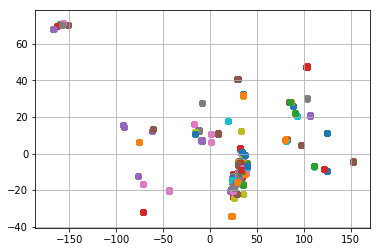

In [26]:
for coords in coords_list:
    plt.scatter(column(coords, 0), column(coords, 1))
plt.grid()

In [27]:
def bounding_boxes_from_coords(coords_list):
    bounding_boxes = []
    for coords in coords_list:
        x_min, x_max = min(column(coords, 0)), max(column(coords, 0))
        y_min, y_max = min(column(coords, 1)), max(column(coords, 1))
        # not [xmin, ymin, xmax, ymax]
        bounding_boxes.append([x_min, y_min, x_max, y_max])
    return bounding_boxes

In [28]:
bounding_boxes_list = bounding_boxes_from_coords(coords_list)

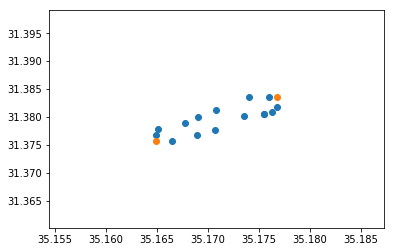

In [48]:
i = 45
coords = coords_list[i]
bounding_boxes = bounding_boxes_list[i]

plt.scatter(column(coords_list[i], 0), column(coords_list[i], 1))
plt.scatter([bounding_boxes[0], bounding_boxes[2]], 
            [bounding_boxes[1], bounding_boxes[3]])

In [32]:
from geopy.geocoders import Nominatim

def countries_from_bounding_boxes(bounding_boxes_list):
    geolocator = Nominatim()
    countries_list = []
    for bb in bounding_boxes_list:
        location1 = geolocator.reverse([bb[1], bb[0]], language='en')
#         location2 = geolocator.reverse(bb[2:4], language='en')
        countries_list.append(location1.address.split(',')[-1].lower()[1:])
    return countries_list


In [33]:
countries_list = countries_from_bounding_boxes(bounding_boxes_list)

In [37]:
project_ids = final_1[0]

In [38]:
data = pd.DataFrame({'id' : project_ids,
              'country' : countries_list,
              'coord_1': column(bounding_boxes_list, 0),
              'coord_2': column(bounding_boxes_list, 1),
              'coord_3': column(bounding_boxes_list, 2),
              'coord_4': column(bounding_boxes_list, 3)})

In [40]:
# data.to_csv('data_100validated.csv', float_format='%.15f')

# For label-maker

In [41]:
data = pd.read_csv('data_100validated.csv')

In [45]:
data

,Unnamed: 0,id,country,coord_1,coord_2,coord_3,coord_4
0,0,5405,tanzania,39.272457,-6.837614,39.275101,-6.835525
1,1,5397,tanzania,39.241958,-6.763698,39.246312,-6.759352
2,2,5370,tanzania,39.318241,-6.993321,39.331807,-6.977738
3,3,5027,tanzania,39.251924,-6.836261,39.272834,-6.818384
4,4,5021,tanzania,39.275785,-6.816047,39.286802,-6.797412
5,5,5011,tanzania,39.268302,-6.820121,39.280407,-6.811936
6,6,5006,senegal,-16.513630,15.970710,-16.508017,16.021120
7,7,4979,algeria,-8.061839,27.717790,-7.994367,27.757547
8,8,4909,upper nile,32.799296,12.359731,32.807212,12.379325
9,9,4857,uganda,32.161730,1.937611,32.174647,1.944859


In [46]:
def show_country_and_coords(i):
    d = data.iloc[i]
    print(d['id'], d['country'], d['coord_1'], d['coord_2'], d['coord_3'], d['coord_4'], sep=', ')

In [47]:
show_country_and_coords(2)

5370, tanzania, 39.318240826, -6.993321134, 39.331807378, -6.977737876
